Definitions of basic gates

In [3]:
import numpy as np
pi = np.pi

up = np.array([1., 0.])
down = np.array([0., 1.])
state = np.kron(up, up)

CX = np.array([[1., 0., 0., 0.,], [0., 1., 0., 0.], [0., 0., 0., 1.], [0., 0., 1., 0.]])
I = np.eye(2)
X = np.array([[0., 1.], [1., 0.]])
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])
CZ = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])


Preliminary pass to remove adjacent, identical gates

In [85]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
# test with some duplicated circuit
qc.h(0)
qc.h(0)
qc.cx(0, 1)
qc.x(0)
qc.x(0)
qc.x(0)
qc.cx(0, 1)
qc.cx(0, 1)
qc.cx(0, 1)

i = len(qc) - 1
while i > 0:
    if qc[i].operation.name == qc[i - 1].operation.name:
        qc.data.pop(i)
        qc.data.pop(i - 1)
        i -= 1  
    i -= 1

print(qc.draw())

          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└───┘┌─┴─┐
q_1: ┤ X ├─────┤ X ├
     └───┘     └───┘


In order to transpile a circuit, the following steps must be implemented:
1. Translate all gates into the native gateset
2. Choose a given ordering
    a. convert everything to swap gates
    b. minimize the number of swap gates
3. Find the best connectivity for this ordering
4. Repeat to find the best ordering and connectivity for a given algorithm

1. Translate all gates into the native gateset (here CZ, X90, Z)

In [4]:
# testing the equivalence library for the CNOT gate

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import CXGate, HGate, RYGate, RXGate, SwapGate
from qiskit.circuit.equivalence_library import EquivalenceLibrary
import numpy as np
pi = np.pi

#done: cnot, h, ry, rz, rx


#not done: xx, yy, zz, 

#to improve: swap, rx

# cnot

cnot = CXGate()

cx_eq = QuantumCircuit(2)
cx_eq.h(1)
cx_eq.cz(0, 1)
cx_eq.h(1) # I guess pass this first, then decompose the hadamard gates?

eq_lib = EquivalenceLibrary()

eq_lib.add_equivalence(cnot, cx_eq)

# h
h = HGate()

h_eq = QuantumCircuit(1)
h_eq.p(pi/2, 0) # not technically in our library; find additional gateset for this
h_eq.x(0)
h_eq.rz(pi/2, 0)
h_eq.x(0)

eq_lib.add_equivalence(h, h_eq)

# y
t = Parameter('t')
ry = RYGate(t)
y_eq = QuantumCircuit(1)
y_eq.x(0)
y_eq.rz(-t, 0)
y_eq.x(0)

eq_lib.add_equivalence(ry, y_eq)

# rx (must be a better way, we end up with X*Z*X, which can probably be expressed as another gate/phase.)
t = Parameter('t')
rx = RXGate(t)
x_eq = QuantumCircuit(1)
x_eq.ry(pi/2, 0)
x_eq.rz(t, 0)
x_eq.ry(pi/2, 0)

eq_lib.add_equivalence(rx, x_eq)

# # swap (also must have better form for this gateset)
# swap = SwapGate()
# swap_eq = QuantumCircuit(2)
# swap_eq.cx(0, 1)
# swap_eq.cx(1, 0)
# swap_eq.cx(0, 1)

# eq_lib.add_equivalence(swap, swap_eq)


ModuleNotFoundError: No module named 'qiskit'

In [7]:
# testing new circuit

circ = QuantumCircuit(2)
# swap as cx
circ.h(0)
print(circ.draw())

# transpile the circuit

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator


basis_gates = ['cz', 'x', 'rz', 'p', 'swap'] # phase and swap aren't actually in our gateset; currently just a crutch. the swap is used to find the best connectivity, then it can be transpiled. 
pm = PassManager()
pm.append(BasisTranslator(eq_lib, basis_gates))

# Step 5: Transpile the circuit
transpiled_qc = pm.run(circ)

# Draw the transpiled circuit
print(transpiled_qc.draw())

     ┌───┐
q_0: ┤ H ├
     └───┘
q_1: ─────
          
     ┌────────┐┌───┐┌─────────┐┌───┐
q_0: ┤ P(π/2) ├┤ X ├┤ Rz(π/2) ├┤ X ├
     └────────┘└───┘└─────────┘└───┘
q_1: ───────────────────────────────
                                    


Test a given DAG circuit

In [36]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from graphviz import Digraph
from qiskit.visualization import dag_drawer

# Create a quantum circuit
qc = QuantumCircuit(6)
qc.cx(0, 3)
qc.cx(0, 5)


# Convert to DAG
dag = circuit_to_dag(qc)




# create a graph in some given ordering (double check this code)

## size
l_x = 2
l_y = 3
import networkx as nx
import matplotlib.pyplot as plt

def initialize_grid(l_x, l_y):
    G = nx.grid_2d_graph(l_y, l_x)
    labels = {node: i for i, node in enumerate(G.nodes())} # maps a node to a given label, so normal ordering
    # Update positions to be used for plotting
    pos = {(x, y): (y, -x) for x, y in G.nodes()} # check
    return G, labels, pos

def draw_grid_with_labels(G, labels, pos): # removed shortest path highlight for now
    """Draw the grid with integer labels and highlight the paths."""
    plt.figure(figsize=(8, 8))
    # Draw nodes using the integer labels directly
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
             font_size=15)

    # colors = ['red', 'green', 'blue', 'yellow']  # Colors for different paths
    # for i, path in enumerate(paths):
    #     path_edges = list(zip(path, path[1:]))
    #     nx.draw_networkx_nodes(G, pos, nodelist=path, node_color=colors[i % len(colors)], node_size=2000)
    #     nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=colors[i % len(colors)], width=2)

    plt.show()

def find_all_shortest_paths(G, labels, start_label, end_label):
    """Find and visualize all shortest paths from start_label to end_label."""
    # Mapping from labels back to nodes for searching
    label_to_node = {label: node for node, label in labels.items()}
    start_node = label_to_node[start_label]
    end_node = label_to_node[end_label]

    paths = list(nx.all_shortest_paths(G, source=start_node, target=end_node))
    path_labels = [[labels[node] for node in path] for path in paths]
    print(f"All shortest paths from {start_label} to {end_label}: {path_labels}")
    return paths


# swap nodes

# initialize grid
G, labels, pos = initialize_grid(l_x, l_y)

# takes integer swap
def swap_labels(G, labels, pos, label1, label2):
    """Swap the labels of two nodes identified by their labels and redraw the graph."""
    node1 = next(node for node, label in labels.items() if label == label1)
    node2 = next(node for node, label in labels.items() if label == label2)

    # Swap the labels in the dictionary
    labels[node1], labels[node2] = labels[node2], labels[node1]

    # Redraw the graph with updated labels
    draw_grid_with_labels(G, labels, pos)

# def swap_labels(G, node1, node2):
#     """
#     Swap labels of two nodes.
#     """
#     # Get current labels
#     label1, label2 = G.nodes[node1]['label'], G.nodes[node2]['label']
    
#     # Swap labels
#     G.nodes[node1]['label'], G.nodes[node2]['label'] = label2, label1
    
#     # Update the drawing
#     labels = nx.get_node_attributes(G, 'label')
#     draw_grid_with_labels(G, pos, labels)

# loop through quantum circuit, find nodes that are 2-qubit gates and see which ones are connected
ops = dag.two_qubit_ops()
dir(ops[0])
dir(ops[0].qargs)
dir(ops[0].qargs[0])
ops[0].qargs[1]._index

qubits = []
for op in range(len(ops)): # for two-qubit gates; extend to 3 qubits eventually
    qubits.append([ops[op].qargs[0]._index, ops[op].qargs[1]._index])
print(qubits)

# find the shortest path and return the number of nodes separating them

# swap qubits until they are adjacent, create new graph, then return to old step to find number of nodes separating them, etc. number of nodes separating them 
# roughly translates to swap gates

# there are several minimal paths for nodes. we want to find the path that minimizes the number of swaps over a circuit.


# swaps = []
# counter = 0

# swap_dict = {}
# for op in range(len(qubits)):
#     qubit1, qubit2 = qubits[op]
#     paths = find_all_shortest_paths(G, labels, qubit1, qubit2)
#     for path in paths:
#         min_path = min(paths) # note it returns as the nodes (tuples)
#         min_path_length = len(min_path) 
#         num_swap = min_path_length - 2 # it includes start + end nodes
#         if num_swap != 0:
#             if op not in swap_dict.keys():
#                 swap_dict[op] = []
#             swap_dict[op].append(path)
#             counter = counter + 1
#             # for i in range(num_swap):
#             #     swap_labels(G, labels, pos, labels[path[-1 - i]], labels[path[-2 - i]])
#             # draw_grid_with_labels(G, labels, pos) 
#         print('tuple is', qubit1, qubit2, 'and the number of swaps is', min_path_length - 2)
#         #print('The number of swaps necessary is:', min_path_length - 2) # since it counts the start and end nodes

# print(swap_dict.keys())
# print(swap_dict[0])

# import itertools

# # generate all combinations of paths for given operations
# def generate_path_combinations(operations_paths):
#     # Extract all sets of paths in the order of operations
#     paths_sets = [paths for paths in operations_paths.values()]
#     # Compute the Cartesian product of these sets
#     all_combinations = list(itertools.product(*paths_sets))
#     return all_combinations

# # generate and print all combinations (fix this)
# min_swaps = -1 
# all_combinations = generate_path_combinations(swap_dict)
# for combo in all_combinations:
#     for step in combo:
#         num_swaps = len(step)
#     for i in range(num_swap):
#         swap_labels(G, labels, pos, labels[path[-1 - i]], labels[path[-2 - i]])
#     draw_grid_with_labels(G, labels, pos) 


# print('total swaps is', sum(swaps))



# there must be a much nicer way of doing this. Maybe comparing the paths would allow us to find 'bad' arrangements and avoid them. 

# for now let's try brute force



# # Draw the grid
# draw_grid_with_labels(G, labels, pos)

# implementing the 'weighted graph' approach
def find_common_subpaths(paths, min_length=2):
    """Finds common consecutive subpaths in a list of paths with a minimum length."""
    common_subpaths = {}
    # Convert each path into tuple for easier manipulation and hashing
    paths = [tuple(path) for path in paths]

    # Check each pair of paths
    for i, path1 in enumerate(paths):
        for j in range(i + 1, len(paths)):
            path2 = paths[j]
            # Compare subpaths of the specified minimum length
            for length in range(min_length, min(len(path1), len(path2)) + 1):
                # Collect subpaths of current length
                subpaths1 = {path1[k:k + length] for k in range(len(path1) - length + 1)}
                subpaths2 = {path2[k:k + length] for k in range(len(path2) - length + 1)}
                # Find intersection
                common = subpaths1.intersection(subpaths2)
                for subpath in common:
                    if subpath in common_subpaths:
                        common_subpaths[subpath].add((i, j))
                    else:
                        common_subpaths[subpath] = {(i, j)}

    # Format results
    result = {subpath: len(index_pairs) for subpath, index_pairs in common_subpaths.items()}
    return result

# Example usage


common_subpaths = find_common_subpaths(paths)
for subpath, count in common_subpaths.items():
    print(f"Subpath {subpath} found in {count} pairs of paths.")



[[0, 3], [0, 5]]
Subpath ((0, 1), (1, 1)) found in 6 pairs of paths.
Subpath ((1, 1), (1, 0)) found in 1 pairs of paths.
Subpath ((0, 1), (1, 1), (1, 0)) found in 1 pairs of paths.
Subpath ((0, 0), (1, 0)) found in 1 pairs of paths.
Subpath ((0, 1), (0, 0)) found in 1 pairs of paths.
Subpath ((0, 1), (0, 0), (1, 0)) found in 1 pairs of paths.
Subpath ((1, 1), (2, 1)) found in 3 pairs of paths.
Subpath ((0, 1), (1, 1), (2, 1)) found in 1 pairs of paths.
Subpath ((1, 0), (2, 0)) found in 1 pairs of paths.


All shortest paths from 1 to 2: [[1, 2]]


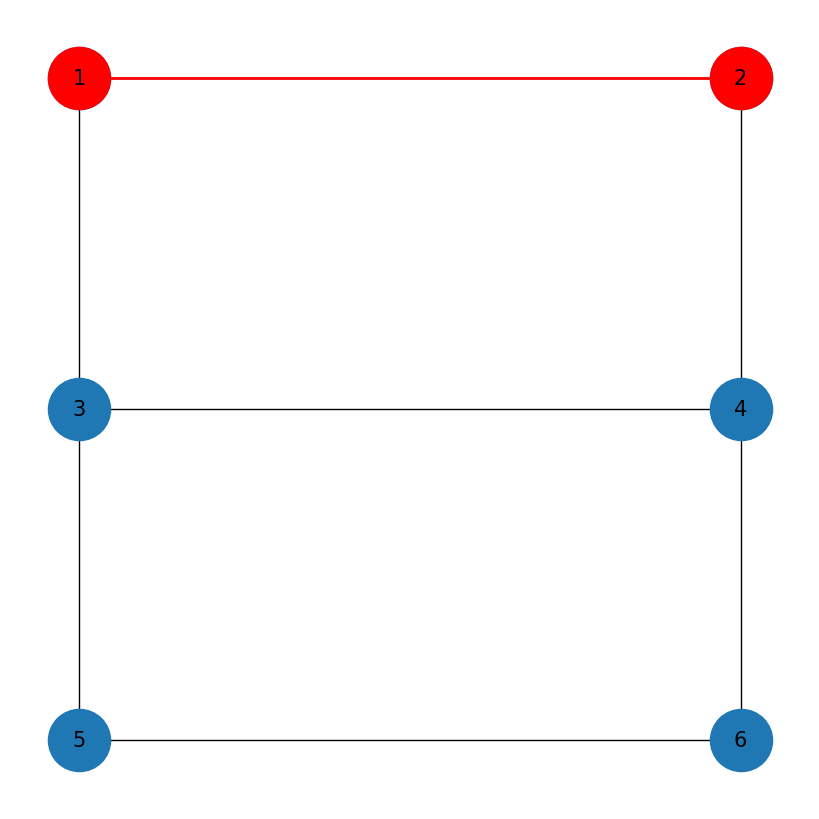

The number of swaps necessary is: 0


In [7]:
# backup


## size
l_x = 2
l_y = 3
import networkx as nx
import matplotlib.pyplot as plt

def initialize_grid(l_x, l_y):
    G = nx.grid_2d_graph(l_y, l_x)
    labels = {node: i + 1 for i, node in enumerate(G.nodes())} # maps a node to a given label, so normal ordering
    # Update positions to be used for plotting
    pos = {(x, y): (y, -x) for x, y in G.nodes()} # check
    return G, labels, pos

def draw_grid_with_labels_and_paths(G, labels, pos, paths):
    """Draw the grid with integer labels and highlight the paths."""
    plt.figure(figsize=(8, 8))
    # Draw nodes using the integer labels directly
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
             font_size=15)

    colors = ['red', 'green', 'blue', 'yellow']  # Colors for different paths
    for i, path in enumerate(paths):
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color=colors[i % len(colors)], node_size=2000)
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=colors[i % len(colors)], width=2)

    plt.show()

def find_all_shortest_paths(G, labels, start_label, end_label):
    """Find and visualize all shortest paths from start_label to end_label."""
    # Mapping from labels back to nodes for searching
    label_to_node = {label: node for node, label in labels.items()}
    start_node = label_to_node[start_label]
    end_node = label_to_node[end_label]

    paths = list(nx.all_shortest_paths(G, source=start_node, target=end_node))
    path_labels = [[labels[node] for node in path] for path in paths]
    print(f"All shortest paths from {start_label} to {end_label}: {path_labels}")
    return paths

# initialize grid
G, labels, pos = initialize_grid(l_x, l_y)

# Calculate and print all shortest paths from 1 to 5
paths = find_all_shortest_paths(G, labels, 1, 2)


# Draw the grid and highlight all shortest paths
draw_grid_with_labels_and_paths(G, labels, pos, paths)

# length of path 
lengths = []
min_path = min(paths) # note it returns as the nodes (tuples)
min_path_length = len(min_path) 

print('The number of swaps necessary is:', min_path_length - 2) # since it counts the start and end nodes


Code to find intersections between paths (draft)

In [2]:
from collections import defaultdict

def find_frequent_subpaths(paths, min_paths):
    """Finds and counts all subpaths that appear in at least min_paths."""
    subpath_counts = defaultdict(int)
    all_subpaths = defaultdict(set)
    
    # Generate all possible subpaths for each path and track which path they came from
    for path_index, path in enumerate(paths):
        for start in range(len(path)):
            for end in range(start + 1, len(path) + 1):
                subpath = tuple(path[start:end])
                all_subpaths[subpath].add(path_index)

    # Filter subpaths that appear in at least min_paths different paths
    frequent_subpaths = {subpath: len(paths_indices) for subpath, paths_indices in all_subpaths.items() if len(paths_indices) >= min_paths}

    return frequent_subpaths

# Example usage
paths = [
    [0, 2, 3, 5, 6],
    [1, 0, 2, 3, 4],
    [0, 2, 3, 6, 7],
    [2, 3, 5, 6],
    [0, 2, 3, 8]
]

min_paths = 3
frequent_subpaths = find_frequent_subpaths(paths, min_paths)
for subpath, count in frequent_subpaths.items():
    print(f"Subpath {subpath} appears in {count} paths")


Subpath (0,) appears in 4 paths
Subpath (0, 2) appears in 4 paths
Subpath (0, 2, 3) appears in 4 paths
Subpath (2,) appears in 5 paths
Subpath (2, 3) appears in 5 paths
Subpath (3,) appears in 5 paths
Subpath (6,) appears in 3 paths


clone where i can continue

functions


In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def initialize_grid(l_x, l_y):
    G = nx.grid_2d_graph(l_y, l_x)
    labels = {node: i for i, node in enumerate(G.nodes())} # maps a node to a given label, so normal ordering
    # Update positions to be used for plotting
    pos = {(x, y): (y, -x) for x, y in G.nodes()} # check
    return G, labels, pos

def draw_grid_with_labels(G, labels, pos): # removed shortest path highlight for now
    """Draw the grid with integer labels and highlight the paths."""
    plt.figure(figsize=(8, 8))
    # Draw nodes using the integer labels directly
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
             font_size=15)

    # colors = ['red', 'green', 'blue', 'yellow']  # Colors for different paths
    # for i, path in enumerate(paths):
    #     path_edges = list(zip(path, path[1:]))
    #     nx.draw_networkx_nodes(G, pos, nodelist=path, node_color=colors[i % len(colors)], node_size=2000)
    #     nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=colors[i % len(colors)], width=2)

    plt.show()

def find_all_shortest_paths(G, labels, start_label, end_label):
    """Find and visualize all shortest paths from start_label to end_label."""
    # Mapping from labels back to nodes for searching
    label_to_node = {label: node for node, label in labels.items()}
    start_node = label_to_node[start_label]
    end_node = label_to_node[end_label]

    paths = list(nx.all_shortest_paths(G, source=start_node, target=end_node))
    path_labels = [[labels[node] for node in path] for path in paths]
    print(f"All shortest paths from {start_label} to {end_label}: {path_labels}")
    return paths


# takes integer swap
def swap_labels(G, labels, pos, label1, label2):
    """Swap the labels of two nodes identified by their labels and redraw the graph."""
    node1 = next(node for node, label in labels.items() if label == label1)
    node2 = next(node for node, label in labels.items() if label == label2)

    # Swap the labels in the dictionary
    labels[node1], labels[node2] = labels[node2], labels[node1]

    # Redraw the graph with updated labels
    draw_grid_with_labels(G, labels, pos)


# implementing the 'weighted graph' approach
def find_common_subpaths(paths, min_length=2):
    """Finds common consecutive subpaths in a list of paths with a minimum length."""
    common_subpaths = {}
    # Convert each path into tuple for easier manipulation and hashing
    paths = [tuple(path) for path in paths]

    # Check each pair of paths
    for i, path1 in enumerate(paths):
        for j in range(i + 1, len(paths)):
            path2 = paths[j]
            # Compare subpaths of the specified minimum length
            for length in range(min_length, min(len(path1), len(path2)) + 1):
                # Collect subpaths of current length
                subpaths1 = {path1[k:k + length] for k in range(len(path1) - length + 1)}
                subpaths2 = {path2[k:k + length] for k in range(len(path2) - length + 1)}
                # Find intersection
                common = subpaths1.intersection(subpaths2)
                for subpath in common:
                    if subpath in common_subpaths:
                        common_subpaths[subpath].add((i, j))
                    else:
                        common_subpaths[subpath] = {(i, j)}

    # Format results
    result = {subpath: len(index_pairs) for subpath, index_pairs in common_subpaths.items()}
    return result

def swap_labels(G, node1, node2):
    """
    Swap labels of two nodes.
    """
    # Get current labels
    label1, label2 = G.nodes[node1]['label'], G.nodes[node2]['label']
    
    # Swap labels
    G.nodes[node1]['label'], G.nodes[node2]['label'] = label2, label1
    
    # Update the drawing
    labels = nx.get_node_attributes(G, 'label')
    draw_grid_with_labels(G, pos, labels)



# swaps = []
# counter = 0

# swap_dict = {}
# for op in range(len(qubits)):
#     qubit1, qubit2 = qubits[op]
#     paths = find_all_shortest_paths(G, labels, qubit1, qubit2)
#     for path in paths:
#         min_path = min(paths) # note it returns as the nodes (tuples)
#         min_path_length = len(min_path) 
#         num_swap = min_path_length - 2 # it includes start + end nodes
#         if num_swap != 0:
#             if op not in swap_dict.keys():
#                 swap_dict[op] = []
#             swap_dict[op].append(path)
#             counter = counter + 1
#             # for i in range(num_swap):
#             #     swap_labels(G, labels, pos, labels[path[-1 - i]], labels[path[-2 - i]])
#             # draw_grid_with_labels(G, labels, pos) 
#         print('tuple is', qubit1, qubit2, 'and the number of swaps is', min_path_length - 2)
#         #print('The number of swaps necessary is:', min_path_length - 2) # since it counts the start and end nodes

# print(swap_dict.keys())
# print(swap_dict[0])

# import itertools

# # generate all combinations of paths for given operations
# def generate_path_combinations(operations_paths):
#     # Extract all sets of paths in the order of operations
#     paths_sets = [paths for paths in operations_paths.values()]
#     # Compute the Cartesian product of these sets
#     all_combinations = list(itertools.product(*paths_sets))
#     return all_combinations

# # generate and print all combinations (fix this)
# min_swaps = -1 
# all_combinations = generate_path_combinations(swap_dict)
# for combo in all_combinations:
#     for step in combo:
#         num_swaps = len(step)
#     for i in range(num_swap):
#         swap_labels(G, labels, pos, labels[path[-1 - i]], labels[path[-2 - i]])
#     draw_grid_with_labels(G, labels, pos) 


# print('total swaps is', sum(swaps))



# there must be a much nicer way of doing this. Maybe comparing the paths would allow us to find 'bad' arrangements and avoid them. 

# for now let's try brute force






More shenanigans

All shortest paths from 1 to 5: [[1, 3, 5]]


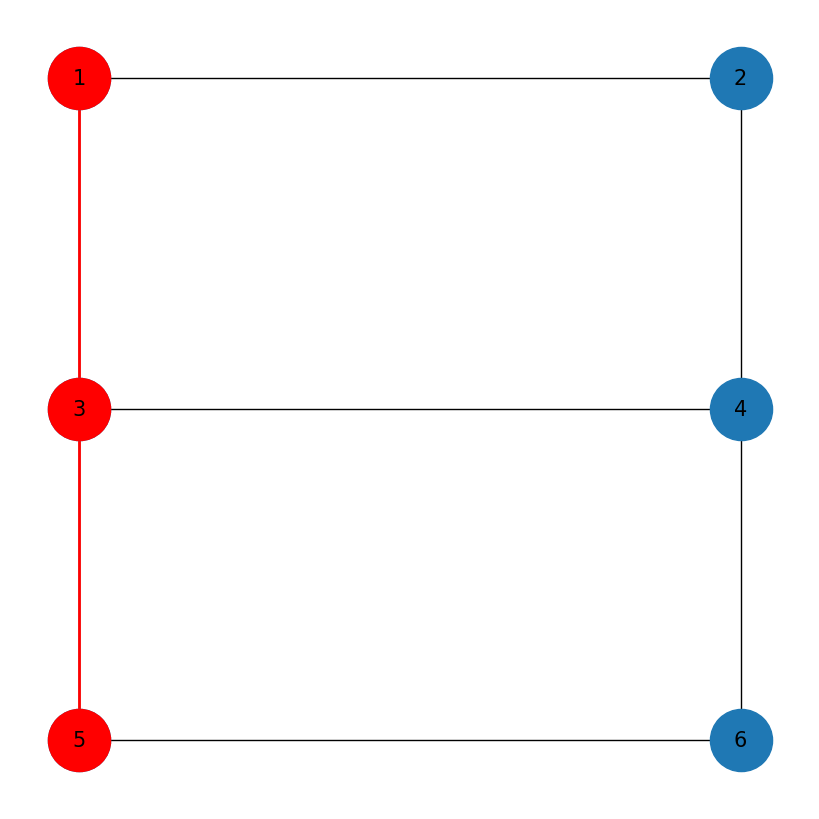

The number of swaps necessary is: 1


In [14]:

def swap_labels(G, labels, pos, label1, label2):
    """Swap the labels of two nodes identified by their labels and redraw the graph."""
    node1 = next(node for node, label in labels.items() if label == label1)
    node2 = next(node for node, label in labels.items() if label == label2)

    # Swap the labels in the dictionary
    labels[node1], labels[node2] = labels[node2], labels[node1]

    # Redraw the graph with updated labels
    draw_grid_with_labels(G, labels, pos)

l_x = 2
l_y = 3
G, labels, pos = initialize_grid(l_x, l_y)

# Calculate and print all shortest paths from 1 to 5
paths = find_all_shortest_paths(G, labels, 1, 5)

# Draw the grid and highlight all shortest paths
draw_grid_with_labels_and_paths(G, labels, pos, paths)

# length of path 
lengths = []
min_path = min(paths) # note it returns as the nodes (tuples)
min_path_length = len(min_path) 

print('The number of swaps necessary is:', min_path_length - 2) # since it counts the start and end nodes
# swap_labels(G, labels, pos, 1, 3)

nodes = [[1, 2], [1, 4], [1, 5]]


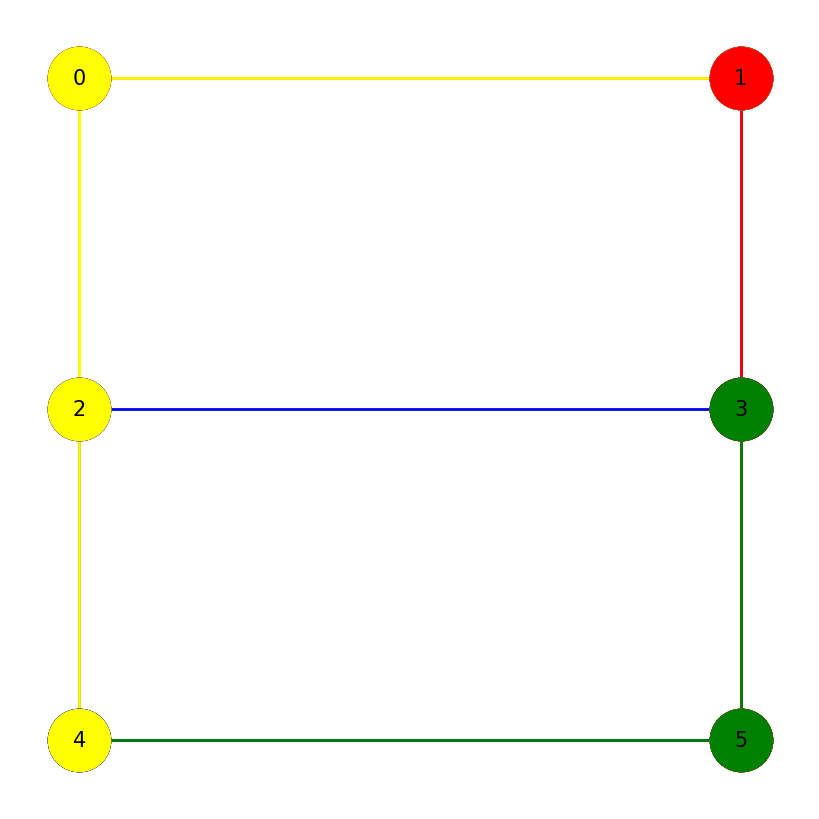

All shortest paths from 0 to 5: [[0, 2, 4, 5], [0, 2, 3, 5], [0, 1, 3, 5]]
All shortest paths from 1 to 2: [[1, 3, 2], [1, 0, 2]]
All shortest paths from 1 to 4: [[1, 3, 5, 4], [1, 3, 2, 4], [1, 0, 2, 4]]
All shortest paths from 1 to 5: [[1, 3, 5]]
All shortest paths from 3 to 5: [[3, 5]]
{(0, 2): 4, (0, 2, 4): 2, (2, 4): 3, (3, 5): 5, (1, 3): 5, (1, 3, 5): 3, (1, 3, 2): 2, (3, 2): 2, (1, 0): 2, (1, 0, 2): 2}


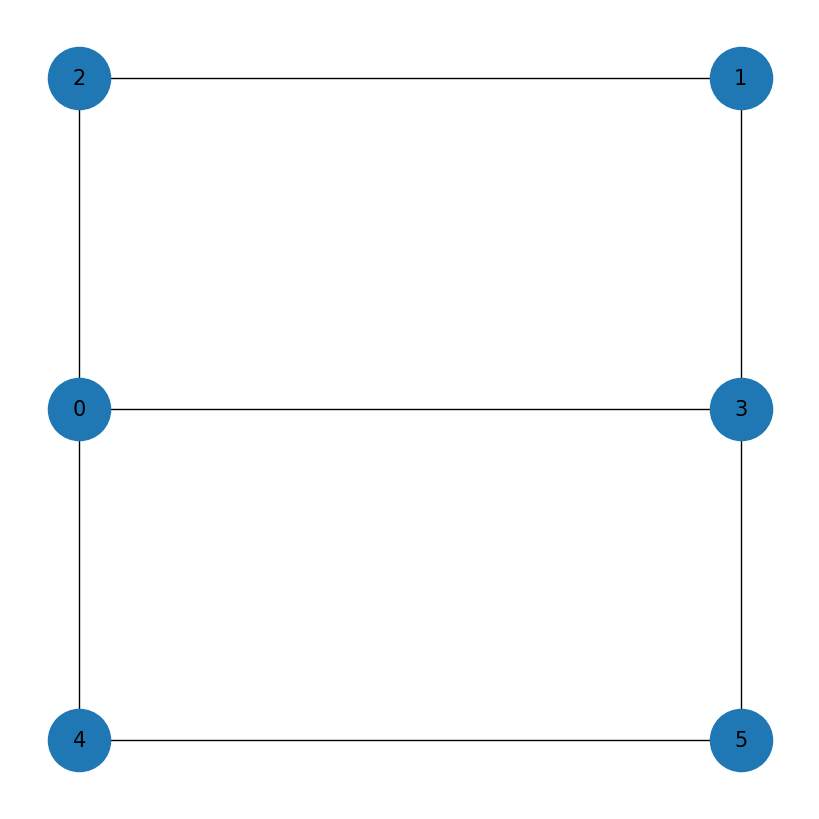

All shortest paths from 0 to 5: [[0, 4, 5], [0, 3, 5]]
All shortest paths from 1 to 2: [[1, 2]]
All shortest paths from 1 to 4: [[1, 3, 5, 4], [1, 3, 0, 4], [1, 2, 0, 4]]
All shortest paths from 1 to 5: [[1, 3, 5]]
All shortest paths from 3 to 5: [[3, 5]]
{(2, 0): 5, (2, 0, 4): 3, (0, 4): 6, (0, 4, 5): 2, (4, 5): 2, (0, 3): 2, (0, 3, 5): 2, (3, 5): 9, (1, 3): 8, (1, 3, 5): 5, (1, 3, 0): 3, (3, 0): 3, (1, 2): 4, (1, 2, 0): 3, (1, 3, 5, 4): 2, (3, 5, 4): 2, (5, 4): 2, (1, 3, 0, 4): 2, (3, 0, 4): 2, (1, 2, 0, 4): 2}


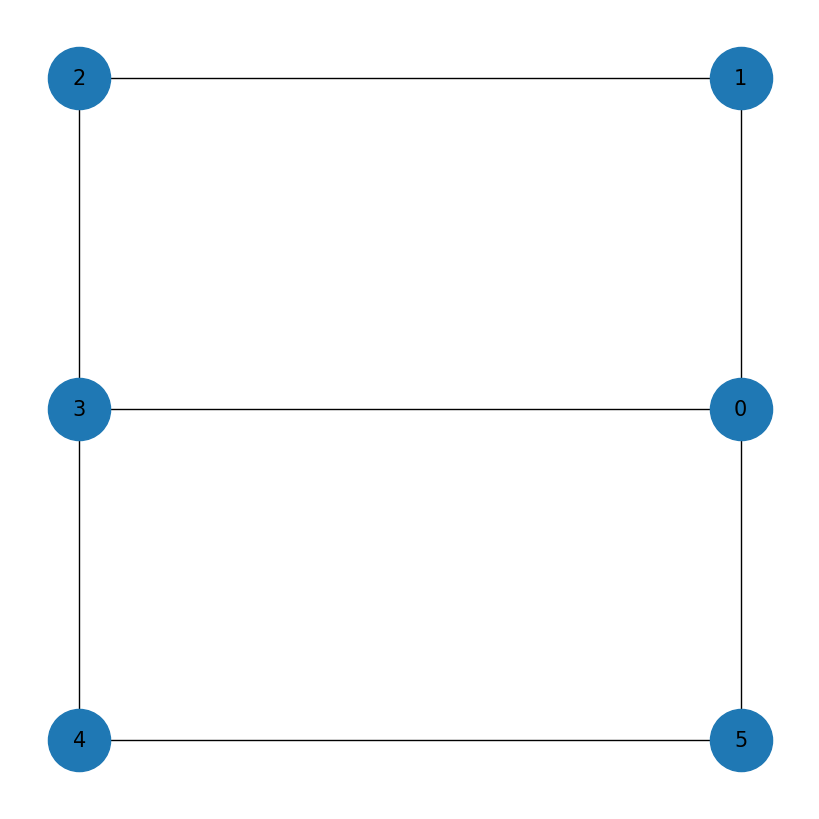

All shortest paths from 0 to 5: [[0, 5]]
All shortest paths from 1 to 2: [[1, 2]]
All shortest paths from 1 to 4: [[1, 0, 5, 4], [1, 0, 3, 4], [1, 2, 3, 4]]
All shortest paths from 1 to 5: [[1, 0, 5]]
All shortest paths from 3 to 5: [[3, 4, 5], [3, 0, 5]]
{(2, 3): 6, (2, 3, 4): 4, (3, 4): 9, (3, 4, 5): 3, (4, 5): 3, (3, 0): 3, (3, 0, 5): 3, (0, 5): 13, (1, 0): 11, (1, 0, 5): 7, (1, 0, 3): 4, (0, 3): 4, (1, 2): 6, (1, 2, 3): 4, (1, 0, 5, 4): 3, (0, 5, 4): 3, (5, 4): 3, (1, 0, 3, 4): 3, (0, 3, 4): 3, (1, 2, 3, 4): 3}


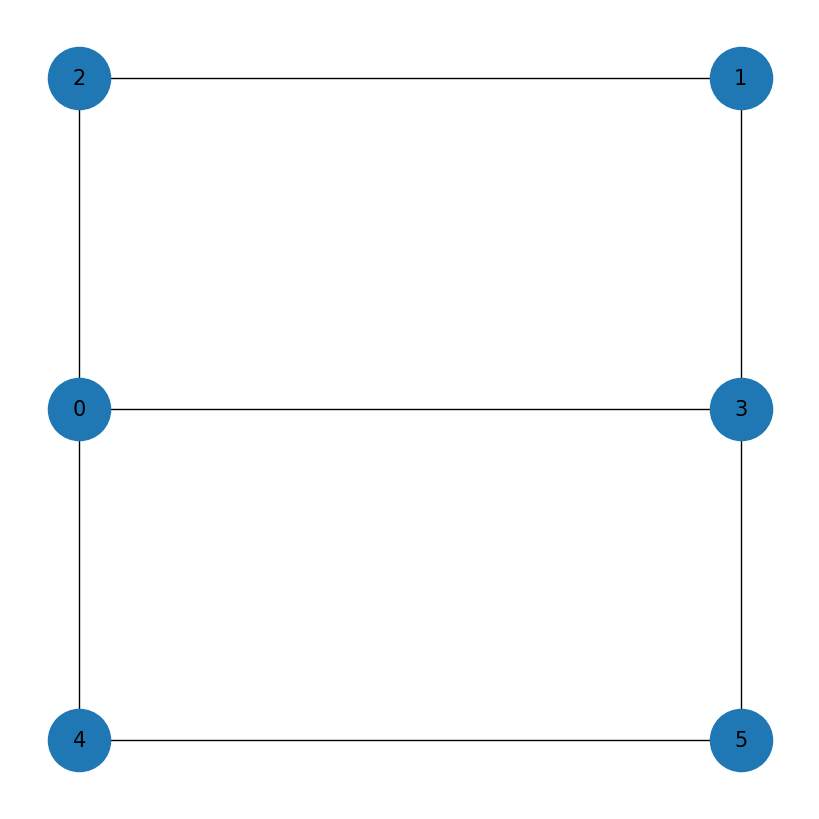

All shortest paths from 0 to 5: [[0, 4, 5], [0, 3, 5]]
All shortest paths from 1 to 2: [[1, 2]]
All shortest paths from 1 to 4: [[1, 3, 5, 4], [1, 3, 0, 4], [1, 2, 0, 4]]
All shortest paths from 1 to 5: [[1, 3, 5]]
All shortest paths from 3 to 5: [[3, 5]]
{(2, 0): 7, (2, 0, 4): 5, (0, 4): 12, (0, 4, 5): 4, (4, 5): 4, (0, 3): 4, (0, 3, 5): 4, (3, 5): 17, (1, 3): 14, (1, 3, 5): 9, (1, 3, 0): 5, (3, 0): 5, (1, 2): 8, (1, 2, 0): 5, (1, 3, 5, 4): 4, (3, 5, 4): 4, (5, 4): 4, (1, 3, 0, 4): 4, (3, 0, 4): 4, (1, 2, 0, 4): 4}


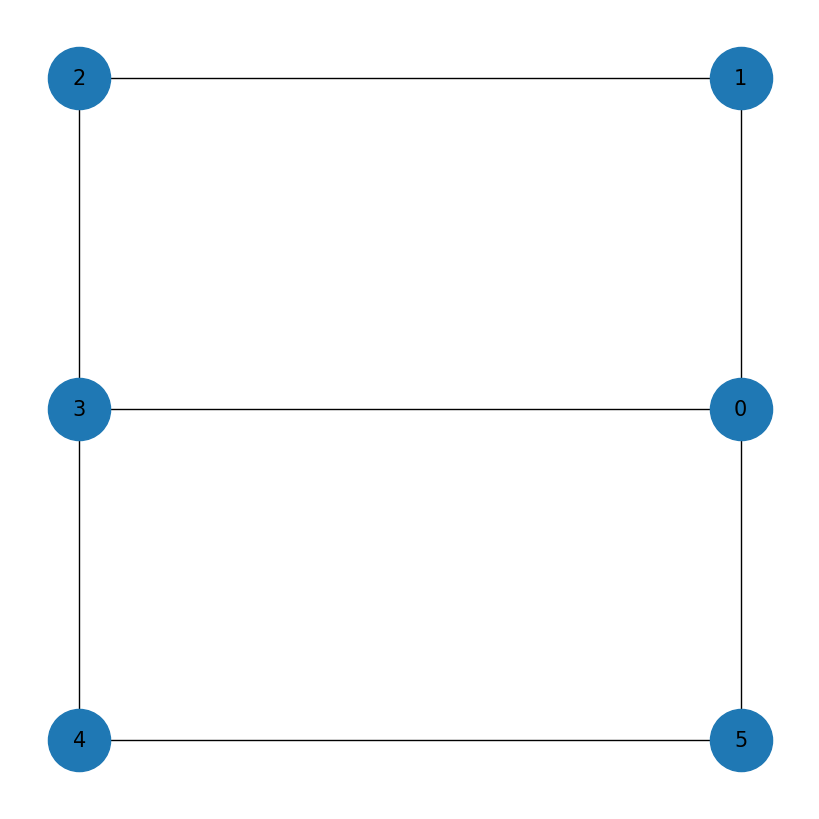

In [57]:
l_x = 2
l_y = 3
G, labels, pos = initialize_grid(l_x, l_y)
# Draw the grid and highlight all shortest paths
draw_grid_with_labels_and_paths(G, labels, pos, paths)

def find_all_shortest_paths(G, labels, start_label, end_label):
    """Find and visualize all shortest paths from start_label to end_label."""
    # Mapping from labels back to nodes for searching
    label_to_node = {label: node for node, label in labels.items()}
    start_node = label_to_node[start_label]
    end_node = label_to_node[end_label]

    paths = list(nx.all_shortest_paths(G, source=start_node, target=end_node))
    path_labels = [[labels[node] for node in path] for path in paths]
    print(f"All shortest paths from {start_label} to {end_label}: {path_labels}")
    return paths


from collections import defaultdict

from collections import defaultdict
from collections import defaultdict

# def find_frequent_subpaths(paths, min_paths, labels):
#     all_subpaths = defaultdict(set)
#     node_to_label = {label: node for node, label in labels.items()}

#     labeled_paths = [[node_to_label[node] for node in path] for path in paths]

#     for path_index, path in enumerate(labeled_paths):
#         path = tuple(path)  # Ensure path is a tuple of integers
#         for start in range(len(path)):
#             for end in range(start + 1, len(path) + 1):
#                 subpath = path[start:end]
#                 all_subpaths[subpath].add(path_index)

#     # Filter subpaths appearing in at least min_paths different paths
#     frequent_subpaths = {subpath: len(paths_indices) for subpath, paths_indices in all_subpaths.items() if len(paths_indices) >= min_paths}
#     return frequent_subpaths
from collections import defaultdict

def find_frequent_subpaths(paths, min_paths, labels):
    """Finds and counts all subpaths that are at least 2 nodes long and appear in at least min_paths."""
    all_subpaths = defaultdict(set)

    # Convert paths from node identifiers to labels before processing
    labeled_paths = [[labels[node] for node in path] for path in paths]

    # Generate all possible subpaths for each path and track which path they came from
    for path_index, path in enumerate(labeled_paths):
        # Generate subpaths that are at least 2 nodes long
        for start in range(len(path)):
            for end in range(start + 2, len(path) + 1):  # start + 2 ensures at least 2 nodes in the subpath
                subpath = tuple(path[start:end])
                all_subpaths[subpath].add(path_index)

    # Filter subpaths that appear in at least min_paths different paths
    frequent_subpaths = {subpath: len(paths_indices) for subpath, paths_indices in all_subpaths.items() if len(paths_indices) >= min_paths}

    return frequent_subpaths

G, labels, pos = initialize_grid(l_x, l_y)

paths = []
nodes = [[0, 5], [1, 2], [1, 4], [1, 5], [3, 5]]
#
for node1, node2 in nodes:
    path = find_all_shortest_paths(G, labels, node1, node2)
    paths.extend(path)  #  ollect all paths

freq_subpaths = find_frequent_subpaths(paths, min_paths=2, labels=labels)

print(freq_subpaths)
label_1, label_2 = min(freq_subpaths)

swap_labels(G, labels, pos, label_1, label_2)
#
for node1, node2 in nodes:
    path = find_all_shortest_paths(G, labels, node1, node2)
    paths.extend(path)  #  ollect all paths

freq_subpaths = find_frequent_subpaths(paths, min_paths=2, labels=labels)
print(freq_subpaths)
label_1, label_2 = min(freq_subpaths)

swap_labels(G, labels, pos, label_1, label_2)


#
for node1, node2 in nodes:
    path = find_all_shortest_paths(G, labels, node1, node2)
    paths.extend(path)  #  ollect all paths

freq_subpaths = find_frequent_subpaths(paths, min_paths=2, labels=labels)

print(freq_subpaths)
label_1, label_2 = min(freq_subpaths)

swap_labels(G, labels, pos, label_1, label_2)
#

for node1, node2 in nodes:
    path = find_all_shortest_paths(G, labels, node1, node2)
    paths.extend(path)  #  ollect all paths

freq_subpaths = find_frequent_subpaths(paths, min_paths=2, labels=labels)

print(freq_subpaths)
label_1, label_2 = min(freq_subpaths)

swap_labels(G, labels, pos, label_1, label_2)

In [ ]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from graphviz import Digraph
from qiskit.visualization import dag_drawer

## size/number of qubits
l_x = 2
l_y = 3

# Create a quantum circuit
qc = QuantumCircuit(6)
qc.cx(0, 3)
qc.cx(0, 5)

# Convert to DAG
dag = circuit_to_dag(qc)


# initialize grid
G, labels, pos = initialize_grid(l_x, l_y)


# loop through quantum circuit, find nodes that are 2-qubit gates and see which ones are connected
ops = dag.two_qubit_ops()
# dir(ops[0])
# dir(ops[0].qargs)
# dir(ops[0].qargs[0])
# ops[0].qargs[1]._index

qubits = []
for op in range(len(ops)): # for two-qubit gates; extend to 3 qubits eventually
    qubits.append([ops[op].qargs[0]._index, ops[op].qargs[1]._index])
print(qubits)

# find minimal paths from the list of qubits

# find common subpaths


# common_subpaths = find_common_subpaths(paths)
# for subpath, count in common_subpaths.items():
#     print(f"Subpath {subpath} found in {count} pairs of paths.")





# find the shortest path and return the number of nodes separating them

# swap qubits until they are adjacent, create new graph, then return to old step to find number of nodes separating them, etc. number of nodes separating them 
# roughly translates to swap gates

# there are several minimal paths for nodes. we want to find the path that minimizes the number of swaps over a circuit.

# # Draw the grid
# draw_grid_with_labels(G, labels, pos)


